# Voltage traces for different $I_{\rm app}$, slow inactivation changes affect all ${\rm Na}^+$ channels

Changes affect all ${\rm Na}^+$ channels: $p_{\rm mut}=1$

Slow inactivation changes: voltage dependence + kinetics

Model: Hu, version with slow inactivation. Defined [here](utils/models/hu_slow_inact/hu_slow_inact.py).



In [1]:
import utils.simu_helper as simu_helper
import utils.plot_helper as plot_helper
import copy
import matplotlib.pyplot as plt

In [2]:
run_simu = True

In [3]:
# model
model_name = "hu_slow_inact"
model = simu_helper.import_model(model_name)

# temporary initial condition
y_0 = [-60, 0.5, 0.5, 0.5, 0.5, 0.5]

# parameter sets to be compared
param_set_id_1 = "wt"
param_set_id_2 = "altered_inact_all_channels"
my_params_wt = model.params_default | getattr(model, f"params_{param_set_id_1}")
my_params_mut = model.params_default | getattr(model, f"params_{param_set_id_2}")

# values of applied current
i_app_vals = (5, 10, 15, 20, 25)

t_start = 10000  # 10 second
t_end = 120000 + t_start  # in ms (2 minutes)

## 1) Simulations

### Prepare simulations

In [4]:
my_simu_wt = simu_helper.Simulation(model.rhs, my_params_wt, y_0, t_end, id=param_set_id_1)
my_simu_mut = simu_helper.Simulation(model.rhs, my_params_mut, y_0, t_end, id=param_set_id_2)
my_simu_mut.model_params["t_start"] = t_start
my_simu_wt.model_params["t_start"] = t_start
simu_all_wt = []
simu_all_mut = []

### Find fixed point when there is no applied current

[-7.05864686e+01  8.67225618e-01  6.39539045e-01  1.78458014e-02
  7.42431874e-01  7.42431874e-01]
[-7.18801377e+01  8.85433215e-01  6.13624811e-01  1.63057722e-02
  7.66385640e-01  4.22629997e-01]


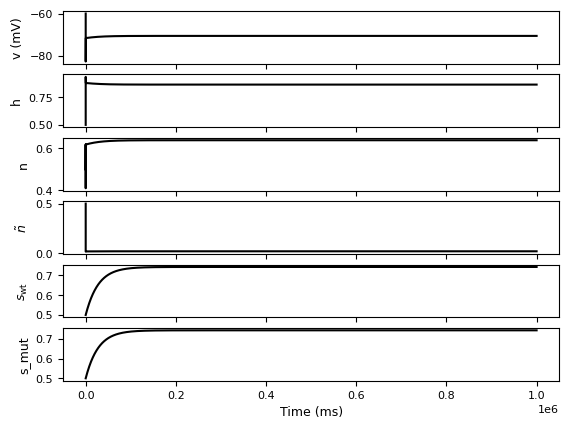

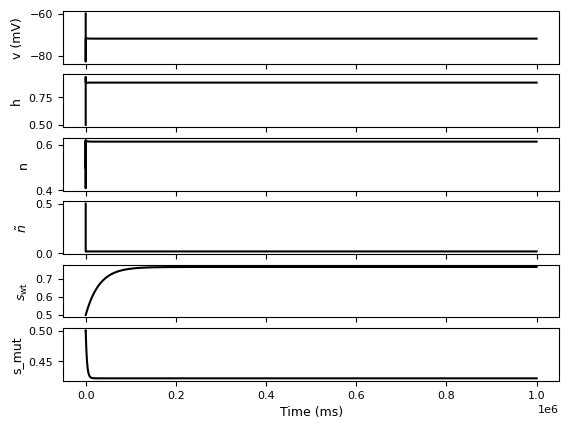

In [5]:
for my_simu in [my_simu_wt, my_simu_mut]:
    my_simu.model_params["i_app"] = 0
    my_simu.t_end = 1000000
    my_simu.run()
    my_simu.plot_time_traces();
    y_0_rest_wt = my_simu.sol.y[:,-1]

    my_simu.y_0 = y_0_rest_wt
    my_simu.t_end = t_end
    print(y_0_rest_wt)


### Run or load simulations

In [6]:
accuracy_scaling = 1000000 
for i_app in i_app_vals:
    print(f"i_app: {i_app}")
    
    # wild type
    my_simu_wt.model_params["i_app_step_val"] = i_app
    if run_simu:
        my_simu_wt.run(rtol=accuracy_scaling*1e-13, atol=accuracy_scaling*1e-19)
        my_simu_wt.save_sol(model_name, i_app)
    else:
        my_simu_wt.load_sol(model_name, i_app)
    simu_all_wt.append(copy.deepcopy(my_simu_wt))

    # mutation
    my_simu_mut.model_params["i_app_step_val"] = i_app
    if run_simu:
        my_simu_mut.run(rtol=accuracy_scaling*1e-13, atol=accuracy_scaling*1e-19)
        my_simu_mut.save_sol(model_name, i_app)
    else:
        my_simu_mut.load_sol(model_name, i_app)
    simu_all_mut.append(copy.deepcopy(my_simu_mut))


i_app: 5
i_app: 10
i_app: 15
i_app: 20
i_app: 25


## 2) Figure

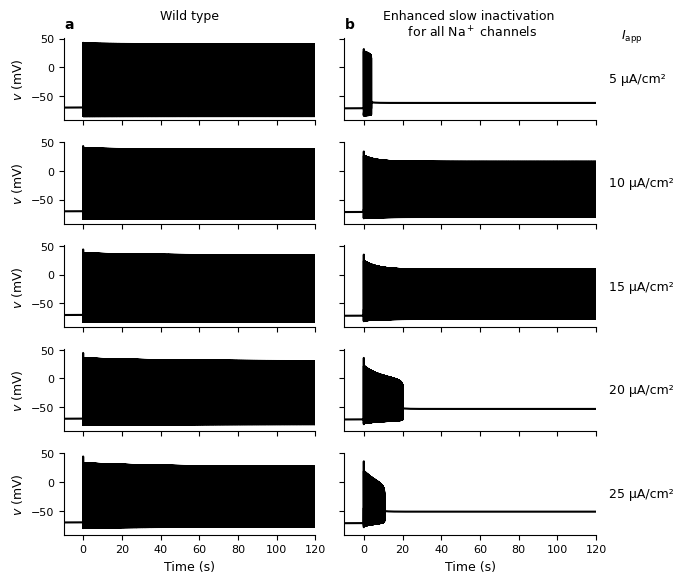

In [7]:
fig, axes = plt.subplots(len(i_app_vals), 2, sharex=True, sharey=True)
fig.set_size_inches(plot_helper.fig_size_default["width"], 5.9)

for idx, i_app in enumerate(i_app_vals):
    # wt plot
    ax = axes[idx, 0]
    simu_all_wt[idx].plot_voltage_trace(ax, unit="second", time_shift=10)
    ax.set_ylabel("$v$ (mV)")

    # mut plot
    ax = axes[idx, 1]
    simu_all_mut[idx].plot_voltage_trace(ax, unit="second", time_shift=10)
    plot_helper.annotate_blended(ax, f"{i_app}"+u" \u00B5A/cm\u00B2", [1.05, 0.5], rotation=0, va="center")


plot_helper.annotate_blended(axes[0, 1], r"$I_{\rm app}$", [1.1, 1], rotation=0)

axes[0, 0].set_title("Wild type", y=1.25, va="top")
axes[0, 1].set_title("Enhanced slow inactivation \n for all "+r"$\rm Na^+$"+" channels", y=1.25, va="top")

axes[-1, 0].set_xlabel("Time (s)")
axes[-1, 1].set_xlabel("Time (s)")
axes[0, 0].set_xlim([-10, 120])

# beautify
for ax in fig.axes:
    ax.spines[['right', 'top']].set_visible(False)

plot_helper.lettering(fig, pos=[0, 1.12], labels=["a", "b", None, None, None, None, None, None, None, None, None, None])
fig.tight_layout()


The figure is here: figures/figure_1.eps


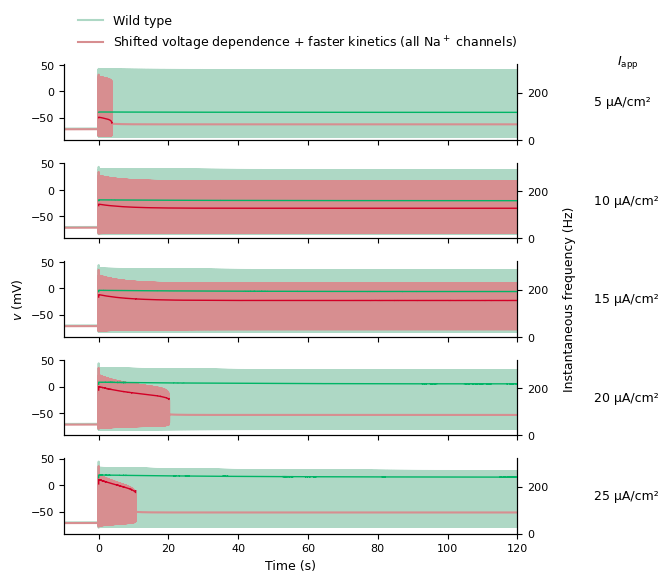

In [8]:
fig, axes = plt.subplots(len(i_app_vals), 1, sharex=True, sharey=True)
fig.set_size_inches(plot_helper.fig_size_default["width"], 5.9)

color_wt = plot_helper.color_wt
color_wt_freq = plot_helper.color_wt_dark
color_mut = plot_helper.color_mut
color_mut_freq = plot_helper.color_mut_dark

for idx, i_app in enumerate(i_app_vals):
    # wt plot
    ax = axes[idx]
    simu_all_wt[idx].plot_voltage_trace(ax, unit="second", time_shift=10, color=color_wt, label="Wild type", zorder=-1)
    ax_freq = simu_all_wt[idx].plot_inst_freq(ax, time_shift=10, color=color_wt_freq)
    ax_freq.set_ylim([0, 320])

    if idx==2:
        ax.set_ylabel("$v$ (mV)")
        ax_freq.set_ylabel("Instantaneous frequency (Hz)")
        ax_freq.yaxis.set_label_coords(x=1.1, y=0.5)

    # mut plot
    simu_all_mut[idx].plot_voltage_trace(ax, unit="second", time_shift=10, color=color_mut, label="Shifted voltage dependence + faster kinetics (all "+r"$\rm Na^+$"+" channels)")
    ax_freq = simu_all_mut[idx].plot_inst_freq(ax, ax_freq=ax_freq, time_shift=10, color=color_mut_freq)
    plot_helper.annotate_blended(ax, f"{i_app}"+u" \u00B5A/cm\u00B2", [1.17, 0.5], rotation=0, va="center")

plot_helper.my_legend(axes[0], loc=[0.02, 1.1], fontsize=9)
plot_helper.annotate_blended(axes[0], r"$I_{\rm app}$", [1.22, 1], rotation=0)

axes[-1].set_xlabel("Time (s)")
axes[0].set_xlim([-10, 120])

    
# beautify
for ax in fig.axes:
    ax.spines[['top']].set_visible(False)

fig.tight_layout()

# save figure
fig_dir = plot_helper.fig_dir
fig_path = f'{fig_dir}/figure_1.eps'
print(f"The figure is here: {fig_path}")
plt.savefig(fig_path, format='eps')    